# Проект: классификация

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [ ]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [ ]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
missing_values = df.isnull().sum()
print("Пропущенные значения в данных:")
print(missing_values)# ваш код

Пропущенные значения в данных:
age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


### Задание 2

In [ ]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

print("Уникальные значения в признаке 'job':")
print(df['job'].unique())
# Подсчет количества значений "unknown" в признаке "job"
unknown_job_count = df[df['job'] == 'unknown']['job'].count()
print("Количество значений 'unknown' в признаке 'job':", unknown_job_count)



# ваш код

Уникальные значения в признаке 'job':
['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
Количество значений 'unknown' в признаке 'job': 70


In [ ]:
# Нахождение моды (наиболее часто встречающееся значение) признака "job"
mode_job = df['job'].mode()[0]

# Замена значений "unknown" на моду
df['job'].replace('unknown', mode_job, inplace=True)

# Подсчет количества значений "unknown" в признаке "job" после замены
unknown_job_count_after = df[df['job'] == 'unknown']['job'].count()
print("Количество значений 'unknown' в признаке 'job' после замены:", unknown_job_count_after)

Количество значений 'unknown' в признаке 'job' после замены: 0


В признаке job пропуски обозначены словом unknown

### Задание 3

In [ ]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# Преобразование признака 'balance' в формат вещественного числа (float)
df["balance"] = df["balance"].apply(lambda x: float(str(x).replace(",", ".").replace("$", "").replace(" ", "").strip()))
print(f"Среднее значение баланса: {df['balance'].mean():.3f}")

Среднее значение баланса: 1529.129


### Задание 4

In [ ]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# Замена пропущенных значений в признаке balance на медианное значение
median_balance = df['balance'].median()
df['balance'].fillna(median_balance, inplace=True)

# Вычисление среднего значения после замены пропущенных значений
mean_balance_after_fillna = df['balance'].mean()

# Вывод результата с округлением до трех знаков после точки-разделителя
print("Среднее значение признака balance после замены пропусков:", round(mean_balance_after_fillna, 3))
# ваш код

Среднее значение признака balance после замены пропусков: 1526.936


### Задание 5

In [ ]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
mod_job = df["job"].mode()[0]
df["job"] = df["job"].apply(lambda x: mod_job if x == "unknown" else x)

# Определение модального значения для education
mod_education = df["education"].mode()[0]
df["education"] = df["education"].apply(lambda x: mod_education if x == "unknown" else x)

# Маска для вычисления среднего баланса
mask = (df["job"] == mod_job) & (df["education"] == mod_education)

# Вычисление среднего баланса для клиентов с самой популярной работой и уровнем образования
mean_balance_popular = df[mask]["balance"].mean()

# Вывод результата с округлением до трех знаков после точки-разделителя
print(f"Средний баланс для клиентов с самой популярной работой и уровнем образования: {mean_balance_popular:.3f}")


# ваш код

Средний баланс для клиентов с самой популярной работой и уровнем образования: 1598.883


### Задание 6

In [ ]:
# удалите все выбросы для признака balance
# обработка пропущенных значений и выбросов для признака balance

Q1 = df["balance"].quantile(0.25)
Q3 = df["balance"].quantile(0.75)
IQR = Q3-Q1
print(f"Нижняя граница поиска выбросов: {Q1-1.5*IQR}")
print(f"Верхняя граница поиска выбросов: {Q3+1.5*IQR}")
df = df[(df["balance"] >= Q1-1.5*IQR) & (df["balance"] <= Q3+1.5*IQR)]

# ваш код

Нижняя граница поиска выбросов: -2241.0
Верхняя граница поиска выбросов: 4063.0


In [ ]:
# Подсчет количества объектов после удаления выбросов

print("Количество объектов после удаления выбросов:", len(df))

Количество объектов после удаления выбросов: 10105


Доп. задание

In [ ]:
from sklearn.ensemble import IsolationForest

# Создание объекта IsolationForest
iso_forest = IsolationForest(random_state=42)

# Обучение модели на признаке "balance"
iso_forest.fit(df[["balance"]].values)

# Получение аномальных значений
anomaly_scores = iso_forest.decision_function(df[["balance"]].values)

# Установка порога для определения аномалий
anomaly_threshold = -0.5

# Маска для выделения аномалий
anomaly_mask = anomaly_scores < anomaly_threshold

# Удаление аномалий из данных
df_without_anomalies = df[~anomaly_mask]

# Вывод количества оставшихся объектов после удаления аномалий
print("Количество объектов после удаления аномалий:", len(df_without_anomalies))


Количество объектов после удаления аномалий: 11162


После удаления аномалий методом  Isolation Forest, количество объектов в данных увеличилось до 11162.  Однако, при анализе полученных данных, необходимо учитывать, что удаление выбросов может повлиять на распределение и структуру данных, поэтому результаты анализа при методе Тьюки и IF отличаются.

## Часть 2:  Разведывательный анализ

### Задание 1

Количество клиентов, открывших депозит: 5289
Количество клиентов, не открывших депозит: 5873


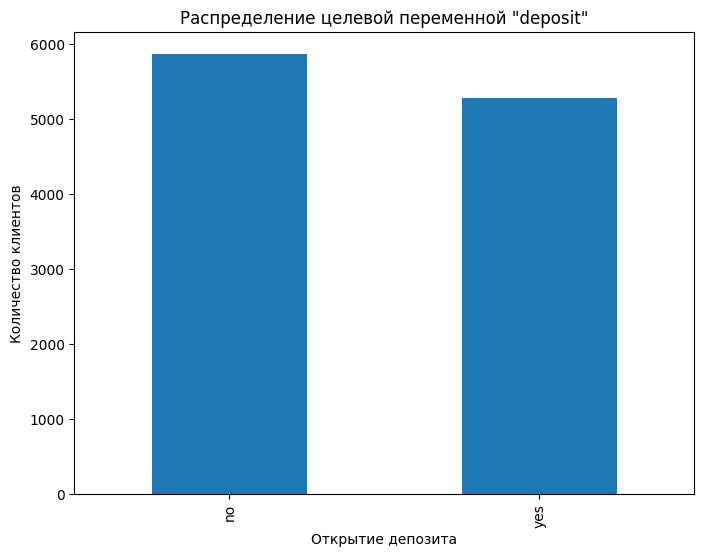

In [ ]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# Подсчет количества клиентов, открывших и не открывших депозит
deposit_counts = df['deposit'].value_counts()
print("Количество клиентов, открывших депозит:", deposit_counts['yes'])
print("Количество клиентов, не открывших депозит:", deposit_counts['no'])

# Визуализация распределения классов
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
deposit_counts.plot(kind='bar')
plt.title('Распределение целевой переменной "deposit"')
plt.xlabel('Открытие депозита')
plt.ylabel('Количество клиентов')
plt.show()
# ваш код

### Задания 2 и 3

In [ ]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
# Вычисление описательных статистик
numeric_cols = ['age', 'balance', 'campaign', 'pdays', 'previous']
desc_stats = df[numeric_cols].describe()
print(desc_stats)
#ваш код

                age       balance      campaign         pdays      previous
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000
mean      41.231948   1526.936033      2.508421     51.330407      0.832557
std       11.913369   3224.829691      2.722077    108.758282      2.292007
min       18.000000  -6847.000000      1.000000     -1.000000      0.000000
25%       32.000000    123.000000      1.000000     -1.000000      0.000000
50%       39.000000    550.000000      2.000000     -1.000000      0.000000
75%       49.000000   1699.000000      3.000000     20.750000      1.000000
max       95.000000  81204.000000     63.000000    854.000000     58.000000


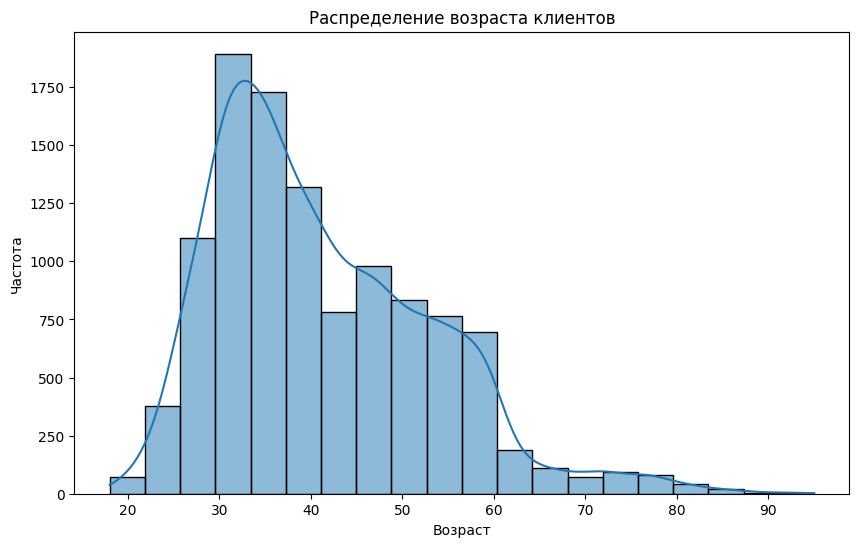

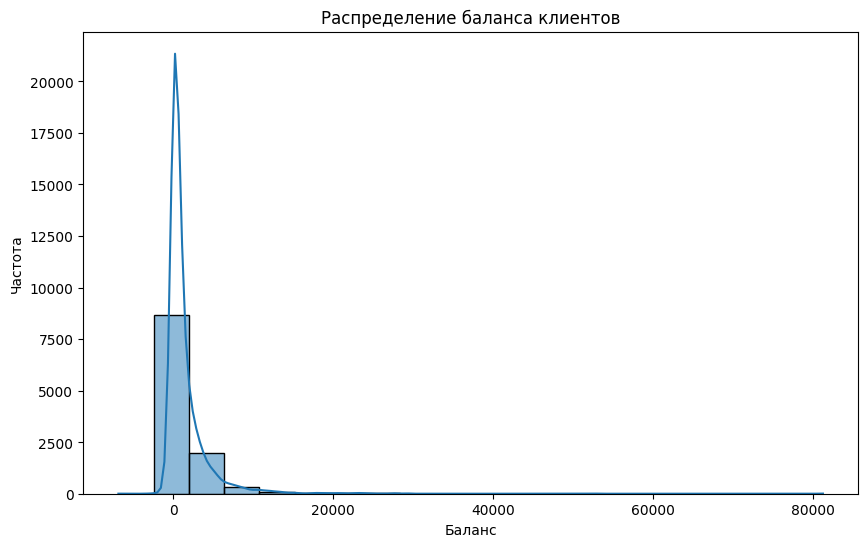

In [ ]:
# Визуализируем распределение возраста
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', bins=20, kde=True)
plt.title('Распределение возраста клиентов')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

# Визуализируем распределение баланса
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='balance', bins=20, kde=True)
plt.title('Распределение баланса клиентов')
plt.xlabel('Баланс')
plt.ylabel('Частота')
plt.show()

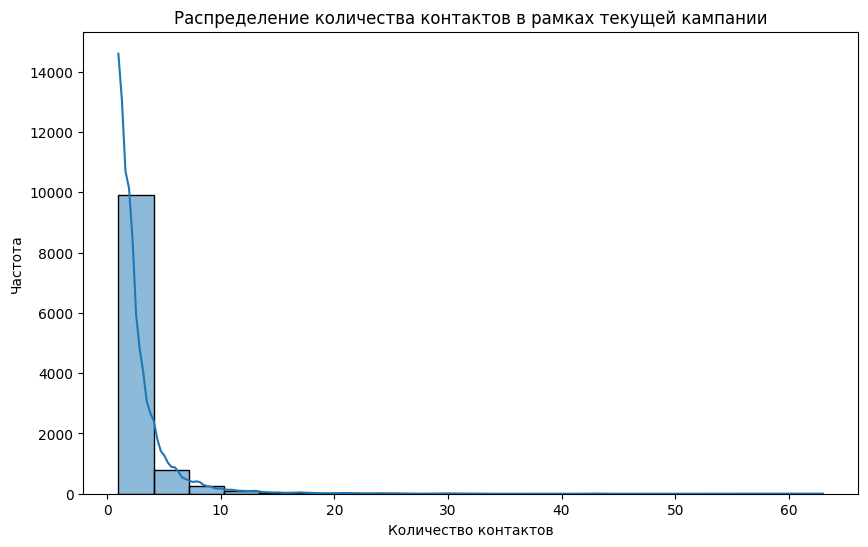

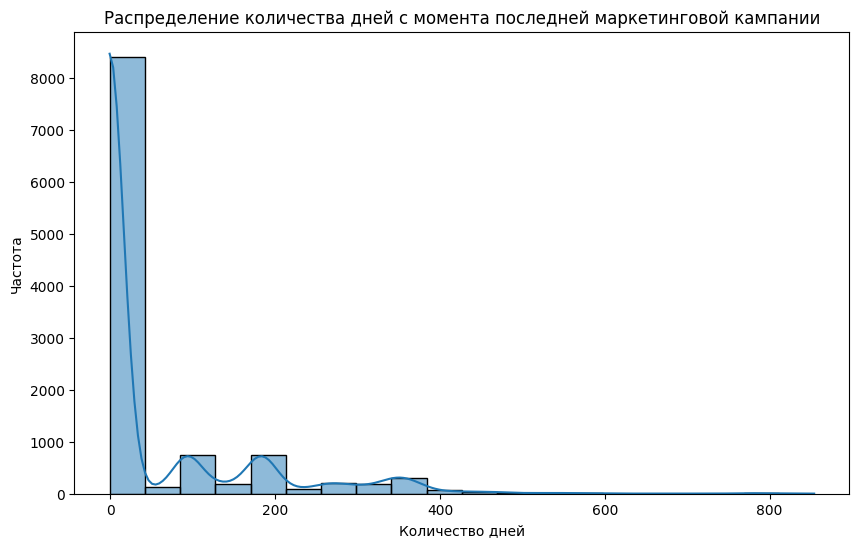

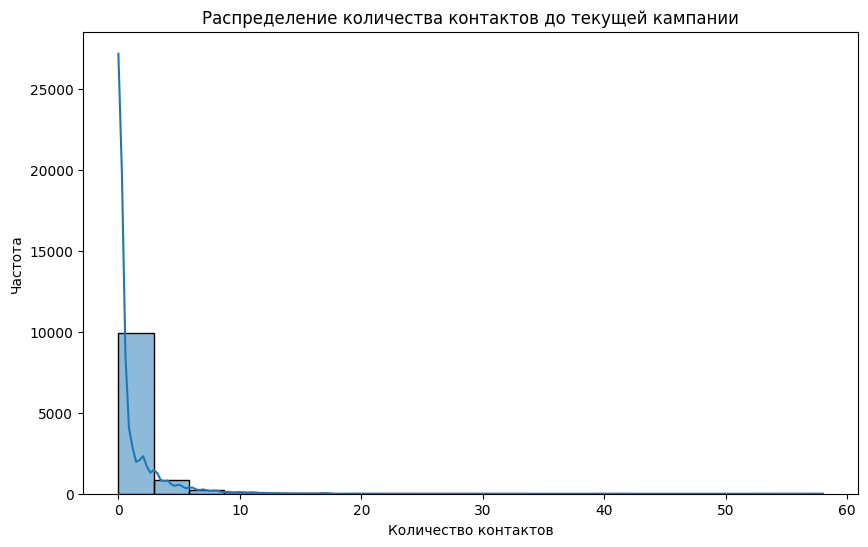

In [ ]:
# Визуализируем распределение количества контактов в рамках текущей кампании (campaign)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='campaign', bins=20, kde=True)
plt.title('Распределение количества контактов в рамках текущей кампании')
plt.xlabel('Количество контактов')
plt.ylabel('Частота')
plt.show()

# Визуализируем распределение количества дней с момента последней маркетинговой кампании (pdays)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='pdays', bins=20, kde=True)
plt.title('Распределение количества дней с момента последней маркетинговой кампании')
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.show()

# Визуализируем распределение количества контактов до текущей кампании (previous)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='previous', bins=20, kde=True)
plt.title('Распределение количества контактов до текущей кампании')
plt.xlabel('Количество контактов')
plt.ylabel('Частота')
plt.show()


В этих трех значениях наблюдаем аномальные показатели.

In [ ]:
# Заменяем значения -1 в признаке pdays на среднее значение
mean_pdays = df['pdays'].mean()
df['pdays'] = df['pdays'].fillna(mean_pdays)


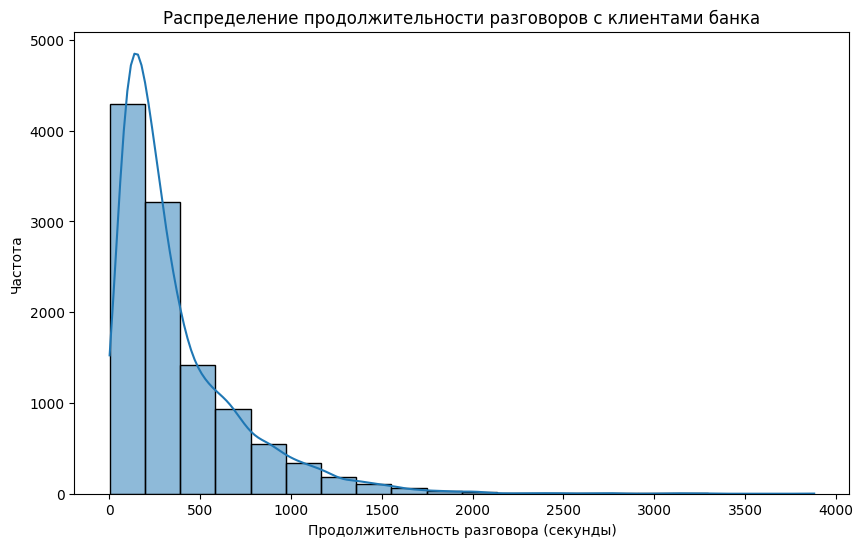

Минимальная продолжительность разговора с клиентом банка (в секундах): 2.0


In [ ]:
# Рассчитываем описательные статистики для продолжительности разговора
duration_stats = df['duration'].describe()

# Выводим минимальное значение продолжительности разговора
min_duration = duration_stats['min']

# Визуализируем распределение продолжительности разговоров
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='duration', bins=20, kde=True)
plt.title('Распределение продолжительности разговоров с клиентами банка')
plt.xlabel('Продолжительность разговора (секунды)')
plt.ylabel('Частота')
plt.show()


print("Минимальная продолжительность разговора с клиентом банка (в секундах):", min_duration)


### Задания 4 и 5

Количество уникальных месяцев, в которых проводилась маркетинговая кампания: 12


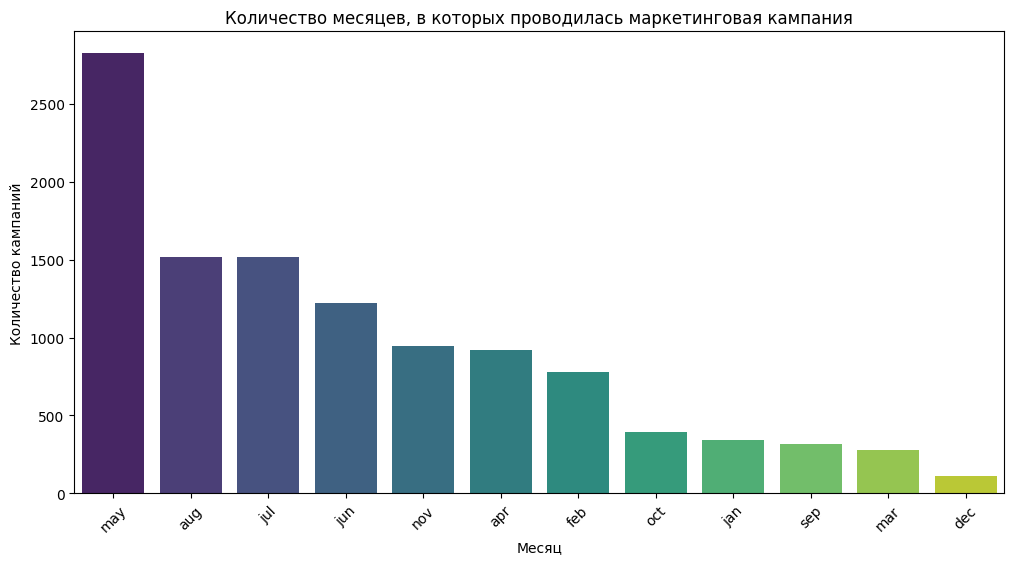

In [ ]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
# Подсчет уникальных значений в столбце 'month'
num_unique_months = df['month'].nunique()
print("Количество уникальных месяцев, в которых проводилась маркетинговая кампания:", num_unique_months)
#ваш код
#постройте визуализации, иллюстрирующие результаты
import matplotlib.pyplot as plt
import seaborn as sns

# Подсчет количества записей для каждого месяца
month_counts = df['month'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, palette='viridis')
plt.title('Количество месяцев, в которых проводилась маркетинговая кампания')
plt.xlabel('Месяц')
plt.ylabel('Количество кампаний')
plt.xticks(rotation=45)
plt.show()


Количество уникальных сфер занятости среди клиентов банка: 11


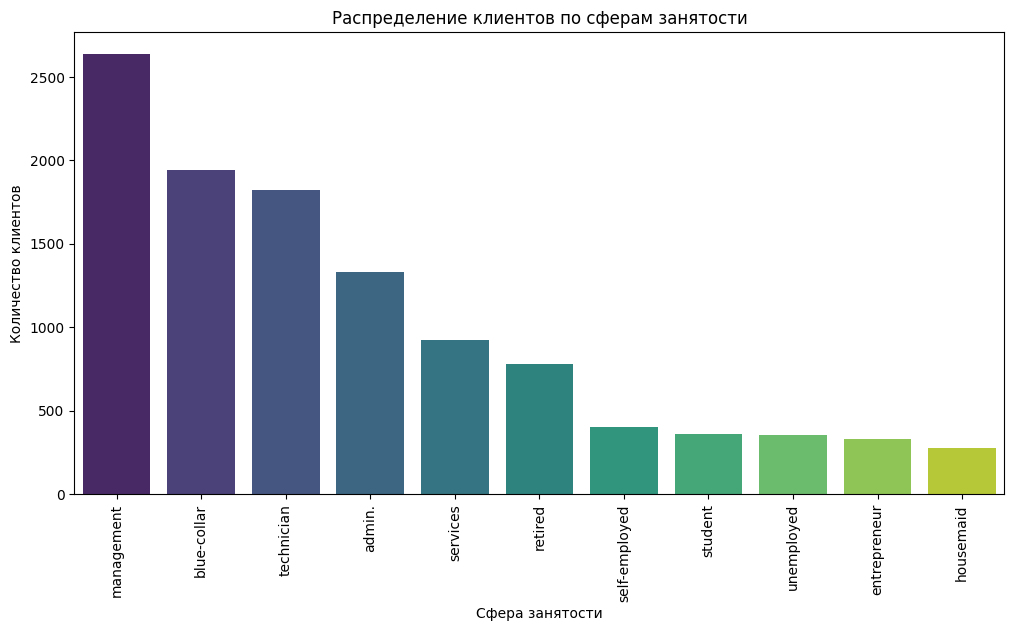

In [ ]:
# Подсчет уникальных значений в столбце 'job'
num_unique_jobs = df['job'].nunique()
print("Количество уникальных сфер занятости среди клиентов банка:", num_unique_jobs)
import matplotlib.pyplot as plt
import seaborn as sns

# Подсчет количества клиентов для каждой сферы занятости
job_counts = df['job'].value_counts()

# Построение диаграммы
plt.figure(figsize=(12, 6))
sns.barplot(x=job_counts.index, y=job_counts.values, palette='viridis')
plt.title('Распределение клиентов по сферам занятости')
plt.xlabel('Сфера занятости')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=90)
plt.show()


### Задание 6

In [ ]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# Группируем данные по статусу предыдущей кампании и целевой переменной
poutcome_deposit_counts = df.groupby(['poutcome', 'deposit']).size().unstack()

# Выводим количество успешных и неуспешных результатов для каждого статуса предыдущей кампании
print("Количество успешных и неуспешных результатов для каждого статуса предыдущей кампании:")
print(poutcome_deposit_counts)

# Вычисляем отношение успешных результатов к неуспешным для каждого статуса предыдущей кампании
poutcome_success_ratio = poutcome_deposit_counts['yes'] / poutcome_deposit_counts['no']

# Находим статус, для которого отношение успешных результатов к неуспешным наибольшее
max_success_ratio_poutcome = poutcome_success_ratio.idxmax()

print("\nСтатус предыдущей кампании, для которого в текущей успехов намного больше, чем неудач:", max_success_ratio_poutcome)
# ваш код

Количество успешных и неуспешных результатов для каждого статуса предыдущей кампании:
deposit     no   yes
poutcome            
failure    610   618
other      230   307
success     93   978
unknown   4940  3386

Статус предыдущей кампании, для которого в текущей успехов намного больше, чем неудач: success


### Задание 7

In [ ]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# Группируем данные по месяцу и результату текущей кампании
month_deposit_counts = df.groupby(['month', 'deposit']).size().unstack(fill_value=0)

# Вычисляем процент неудач для каждого месяца
month_failure_rates = month_deposit_counts['no'] / (month_deposit_counts['yes'] + month_deposit_counts['no'])

# Находим месяц с максимальным процентом неудач
worst_month = month_failure_rates.idxmax()

print("Месяц с самым большим процентом неудач в текущей маркетинговой кампании:", worst_month)
# ваш код

Месяц с самым большим процентом неудач в текущей маркетинговой кампании: may


### Задание 8

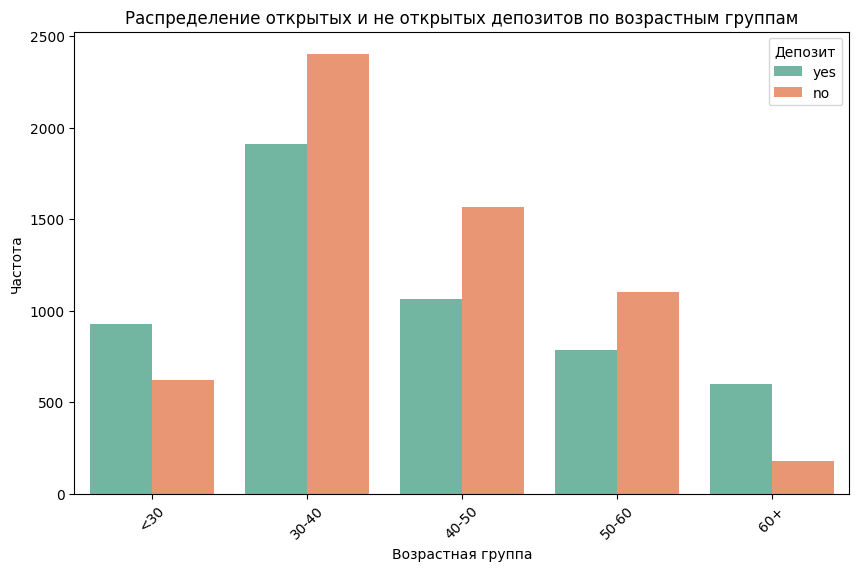

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Определяем границы возрастных категорий
age_bins = [0, 30, 40, 50, 60, float('inf')]
age_labels = ['<30', '30-40', '40-50', '50-60', '60+']

# Создаем новую переменную "age_group" с возрастными категориями
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Строим гистограмму распределения открытых и не открытых депозитов для каждой возрастной группы
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age_group', hue='deposit', palette='Set2')
plt.title('Распределение открытых и не открытых депозитов по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.legend(title='Депозит', loc='upper right')
plt.show()


Более склонны открывать депозит, чем отказываться в группах: < 30, и > 60, но группа 31-40 более многочислена.

### Задания 9 и 10

Text(0.5, 1.0, 'Соотношение открытых и не открытых депозитов по семейному положению')

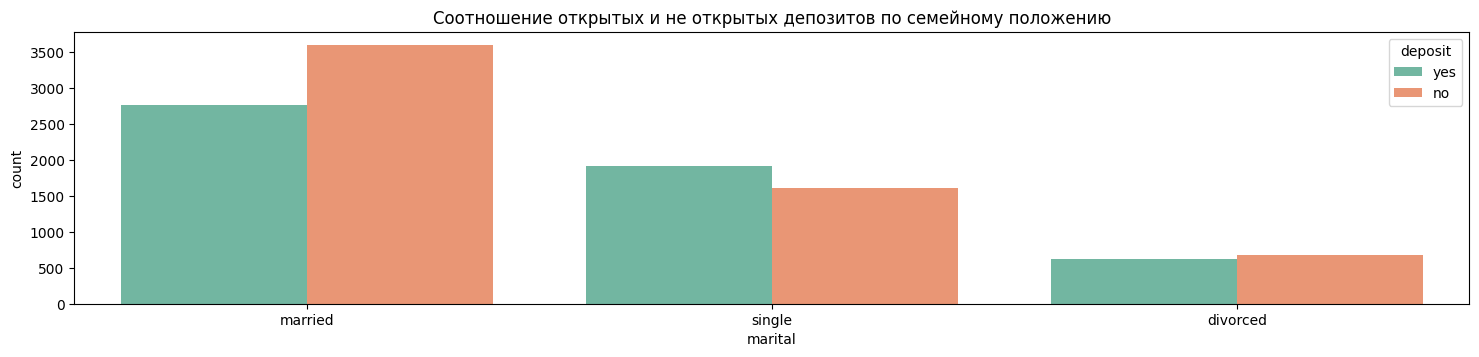

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
# Создание визуализаций для семейного положения, уровня образования и сферы занятости
plt.figure(figsize=(18, 12))

# Семейное положение
plt.subplot(3, 1, 1)
sns.countplot(data=df, x='marital', hue='deposit', palette='Set2')
plt.title('Соотношение открытых и не открытых депозитов по семейному положению')



В соотношении открытых к не открытым депозитам выделяем показатель single, но выборка married больше по количеству.

Text(0.5, 1.0, 'Соотношение открытых и не открытых депозитов по уровню образования')

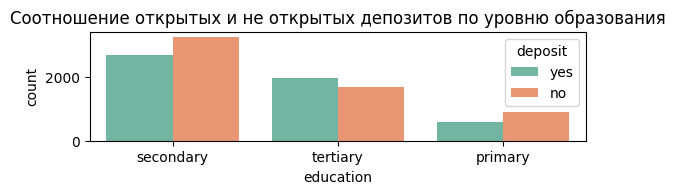

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
# Уровень образования
plt.subplot(3, 1, 2)
sns.countplot(data=df, x='education', hue='deposit', palette='Set2')
plt.title('Соотношение открытых и не открытых депозитов по уровню образования')


Люди с высшим образованием более склонны открывать депозит, чем отказываться от него, но выборка secondary более многочислена.

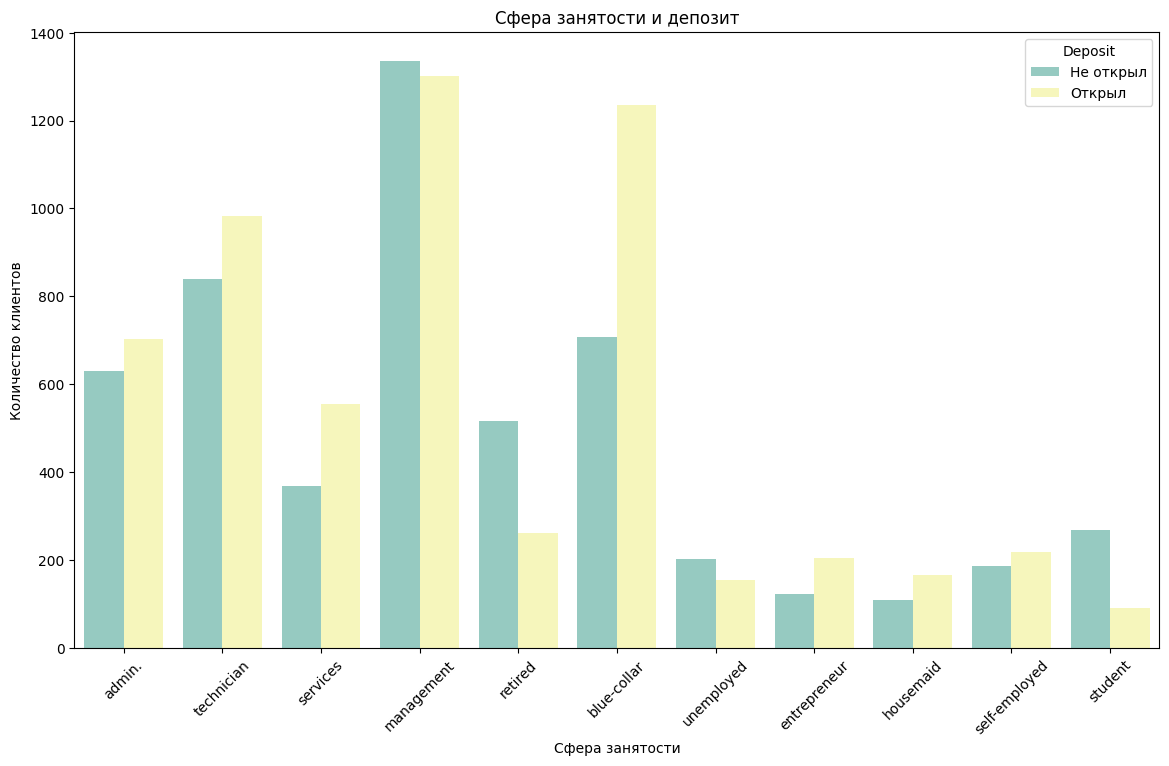

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='job', hue='deposit', palette='Set3')
plt.title('Сфера занятости и депозит')
plt.xlabel('Сфера занятости')
plt.ylabel('Количество клиентов')
plt.legend(title='Deposit', loc='upper right', labels=['Не открыл', 'Открыл'])
plt.xticks(rotation=45)
plt.show()


Склоны принимать решение в пользу отрытия депозита: пенсионеры, студенты, безработные. Однако по колличеству значительно превосходят менеджеры, технические специалисты, офисные работники и администраторы.

### Задание 11

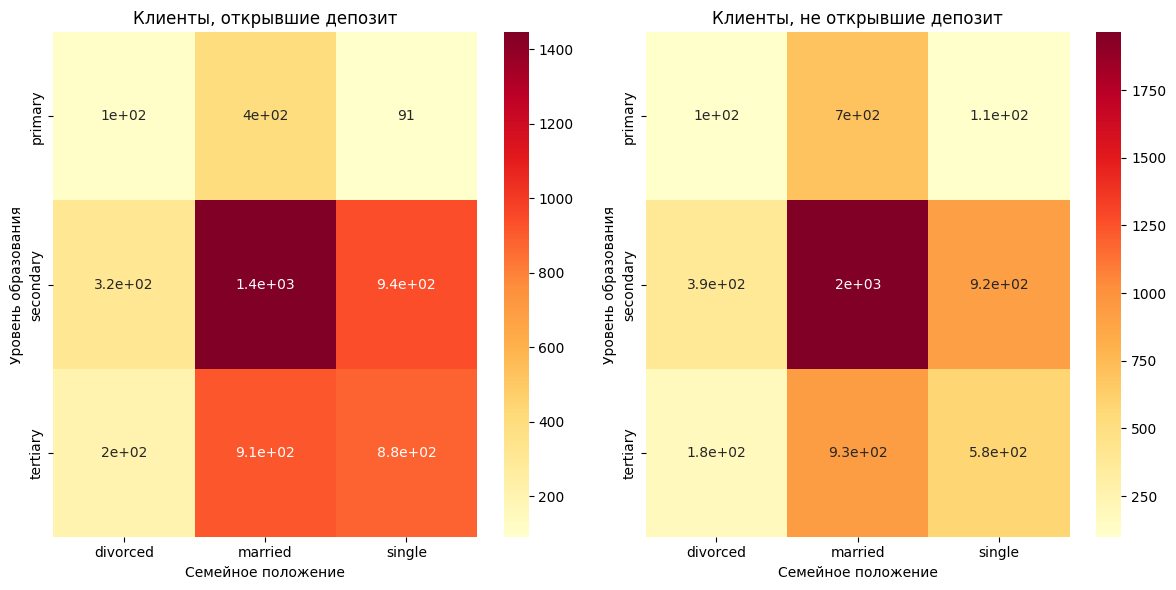

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Создание сводных таблиц для клиентов, открывших и не открывших депозиты
deposit_pivot = df.loc[df['deposit'] == 'yes'].pivot_table(index='education', columns='marital', values='deposit', aggfunc='count')
no_deposit_pivot = df.loc[df['deposit'] == 'no'].pivot_table(index='education', columns='marital', values='deposit', aggfunc='count')

# Построение тепловых карт
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(deposit_pivot, annot=True, cmap='YlOrRd')
plt.title('Клиенты, открывшие депозит')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')

plt.subplot(1, 2, 2)
sns.heatmap(no_deposit_pivot, annot=True, cmap='YlOrRd')
plt.title('Клиенты, не открывшие депозит')
plt.xlabel('Семейное положение')
plt.ylabel('Уровень образования')

plt.tight_layout()
plt.show()


по тепловой карте наблюдаем, что наибольшее количество людей открывших депозит наблюдаем среди женатых со средним образованием.

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder

# Создание объекта LabelEncoder
le = LabelEncoder()

# Преобразование признака "education"
df['education'] = le.fit_transform(df['education'])

# Вычисление суммы полученных значений для признака "education"
education_sum = df['education'].sum()

print("Сумма значений для признака 'education':", education_sum)


Сумма значений для признака 'education': 13351


### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Преобразование целевой переменной "deposit" в бинарный признак
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

# Вычисление стандартного отклонения по преобразованной в корректный вид целевой переменной "deposit"
deposit_std = df['deposit'].std()

print("Стандартное отклонение по преобразованной в корректный вид целевой переменной 'deposit':", round(deposit_std, 3))


Стандартное отклонение по преобразованной в корректный вид целевой переменной 'deposit': 0.499


In [ ]:
# Преобразование бинарных переменных 'default', 'housing' и 'loan'
binary_columns = ['default', 'housing', 'loan']

for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# Вычисление стандартного отклонения для каждой из модифицированных бинарных переменных
default_std = df['default'].std()
housing_std = df['housing'].std()
loan_std = df['loan'].std()

print("Стандартное отклонение для 'default':", default_std)
print("Стандартное отклонение для 'housing':", housing_std)
print("Стандартное отклонение для 'loan':", loan_std)


Стандартное отклонение для 'default': 0.12176148721965067
Стандартное отклонение для 'housing': 0.49929947601337055
Стандартное отклонение для 'loan': 0.3371976194122011


In [ ]:
# Вычисление среднего арифметического для каждой переменной
default_mean = df['default'].mean()
housing_mean = df['housing'].mean()
loan_mean = df['loan'].mean()

# Сложение результатов
total_mean = default_mean + housing_mean + loan_mean

# Вывод итогового значения, округленного до трех знаков после точки-разделителя
print("Итоговое значение (округленное до трех знаков после точки-разделителя):", round(total_mean, 3))


Итоговое значение (округленное до трех знаков после точки-разделителя): 0.619


### Задание 4

In [ ]:
# создайте дамми-переменные
cols_to_dummy = ["job", "marital", "contact", "month", "poutcome"]
df = pd.get_dummies(df, columns=cols_to_dummy, dtype=int)

In [ ]:
print(f"Количество признаков в датасете не считая целевую переменную с уже добавленные dummy-переменные, но до удаления  5 номинальных.  {df.shape[1] - 1 + 5 }")

Количество признаков в датасете не считая целевую переменную с уже добавленные dummy-переменные, но до удаления  5 номинальных.  50


### Задания 5 и 6

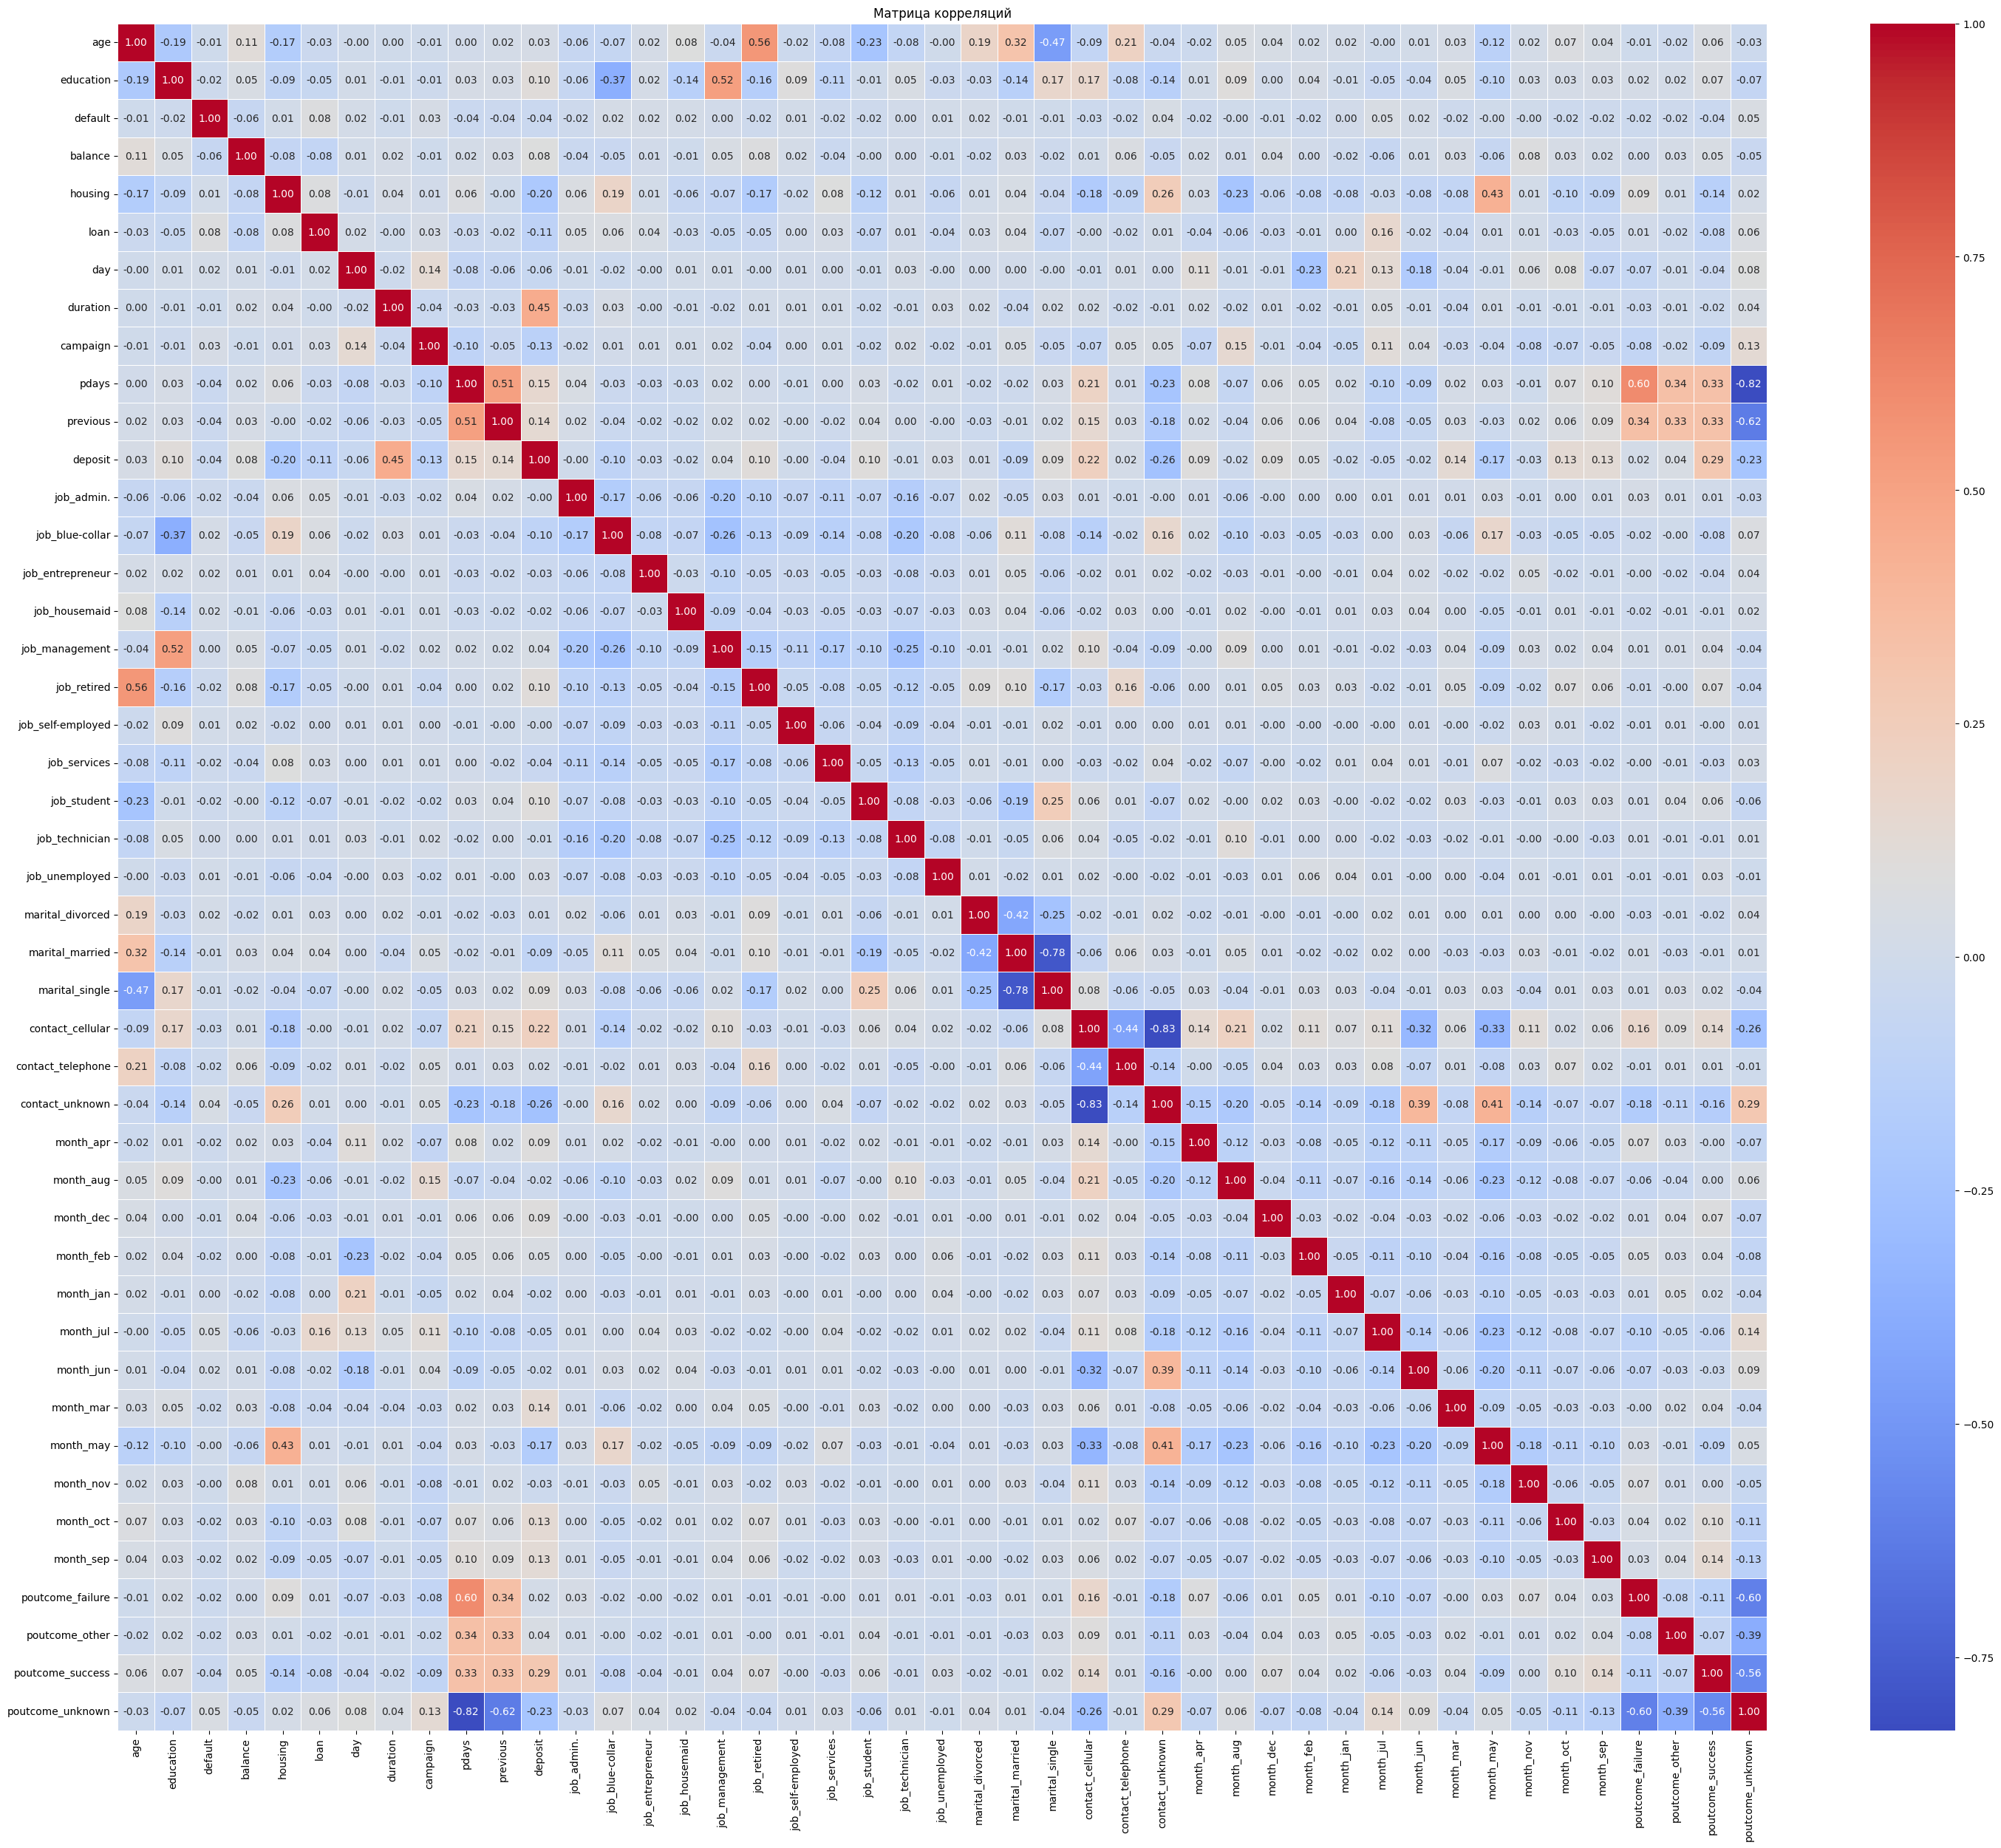

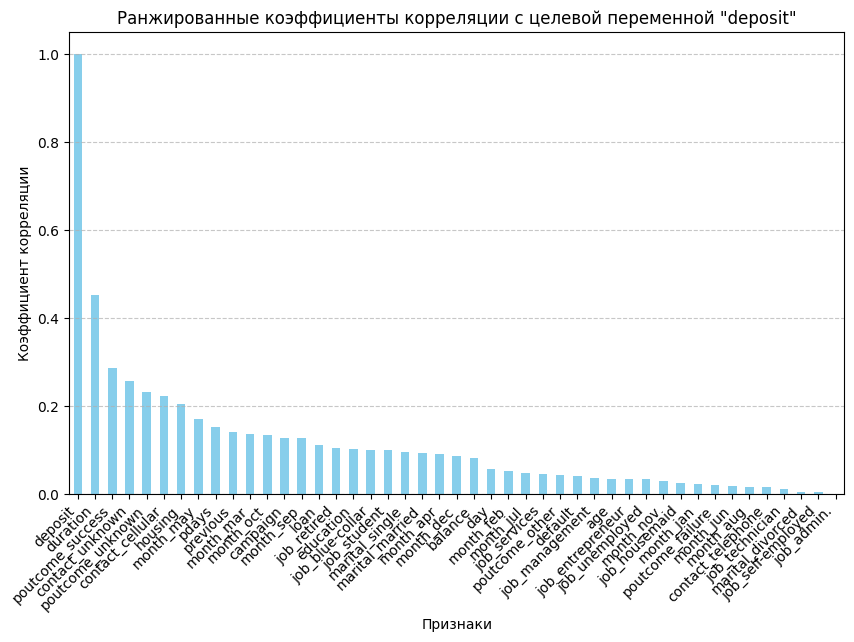

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарност
# Построение матрицы корреляций
corr_matrix = (df.corr(numeric_only=True))

# Построение тепловой карты
plt.figure(figsize=(36, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()
# Получение абсолютных значений коэффициентов корреляции с целевой переменной и их сортировка
correlation_with_target = corr_matrix['deposit'].abs().sort_values(ascending=False)

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
correlation_with_target.plot(kind='bar', color='skyblue')
plt.title('Ранжированные коэффициенты корреляции с целевой переменной "deposit"')
plt.xlabel('Признаки')
plt.ylabel('Коэффициент корреляции')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Из графика мы можем увидеть, что целевая переменная больше всего коррелирует с переменной  duration (0.46). Следовательно, у целевой переменной есть умеренная зависимость от времени. Далее идут переменные poutcome_success (0.29)  и contact_cellular (0.22), они также коррелируют с целевой переменной, но связь между ними и целевой переменной уже можно отнести к слабой.  Среди признаков мультиколлинеарность (значение более 0,9) отсутствует. Столбчатая диаграмма показала корреляцию в порядке убывания с переменными  contact_unknown -0.25 и poutcome_unknown -0.23, но она обратная

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели
# Вывод размера тестовой выборки
print("Размер тестовой выборки:", len(y_test))

Размер тестовой выборки: 3684


In [ ]:
mean_target = y_test.mean()
print("Среднее значение целевой переменной на тестовой выборке:", round(mean_target, 2))


Среднее значение целевой переменной на тестовой выборке: 0.47


In [ ]:
# Преобразование категориальной переменной 'age_group' в числовой формат
df['age_group'] = df['age_group'].cat.codes

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
X_train_num = X_train.select_dtypes(include=["number"])
feature_sel = SelectKBest(k=15, score_func=f_classif)
X_new_train = feature_sel.fit_transform(X_train_num, y_train)
sel_feature_train = X_train_num.columns[feature_sel.get_support()]
sel_feature_train = pd.DataFrame(X_new_train, columns=sel_feature_train)
# Получим список названий отобранных признаков
selected_feature_names_train = sel_feature_train.columns.tolist()
print(selected_feature_names_train)

['housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


In [ ]:
X_test_num = X_test.select_dtypes(include=["number"])
X_test_new = feature_sel.transform(X_test_num)
sel_feature_test = X_test_num.columns[feature_sel.get_support()]

sel_feature_test = pd.DataFrame(X_test_new, columns=sel_feature_test)
feature_names = df.columns.tolist()
# Получить названия отобранных признаков
selected_features_name_test = sel_feature_test.columns.tolist()

print(selected_features_name_test)

['housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'job_blue-collar', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


In [ ]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()

scaler.fit(sel_feature_train)

X_train_norm = scaler.transform(sel_feature_train)
X_test_norm = scaler.transform(sel_feature_test)

print(f"Среднее арифметическое для первого придиктора {X_test_norm[:, 1].mean():.3f}")


Среднее арифметическое для первого придиктора 0.135


Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_model = linear_model.LogisticRegression(solver="sag", random_state=42, max_iter=1000)

log_model.fit(X_train_norm, y_train)

y_pred_train = log_model.predict(X_train_norm)
y_pred_test = log_model.predict(X_test_norm)

print(f"Значение accuracy на тестовой выборке {metrics.accuracy_score(y_test, y_pred_test):.3f}")

Значение accuracy на тестовой выборке 0.812


### Задания 2,3,4

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Создание списка для сохранения значений accuracy для каждой глубины
accuracies = []

# Попробуем разные значения для max_depth
for depth in range(1, 11):
    # Создание модели решающего дерева с заданной глубиной
    tree_model = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=depth)

    # Обучение модели на обучающей выборке
    tree_model.fit(X_train_norm, y_train)

    # Прогнозирование значений на тестовой выборке
    y_pred_test = tree_model.predict(X_test_norm)

    # Вычисление accuracy и добавление его в список
    accuracy = metrics.accuracy_score(y_test, y_pred_test)
    accuracies.append(accuracy)

# Вывод результата
print("Максимальная accuracy:", max(accuracies))

# Нахождение индекса максимального значения в списке accuracies
best_depth_index = accuracies.index(max(accuracies))

# Определение наилучшей глубины дерева
best_depth = best_depth_index + 1

print("индекс максимального значения accuracy в списке accuracies: ", best_depth_index)
print("наилучшая глубина дерева: ", best_depth )


Максимальная accuracy: 0.8143322475570033
индекс максимального значения accuracy в списке accuracies:  7
наилучшая глубина дерева:  8


In [ ]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Задание параметров для перебора
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Создание модели решающих деревьев
dt_model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Поиск наилучших параметров с помощью GridSearchCV
grid_search = GridSearchCV(dt_model, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_norm, y_train)

# Получение наилучших параметров и предсказание на тестовой выборке
best_params = grid_search.best_params_
y_pred_dt_grid = grid_search.predict(X_test_norm)

# Оценка метрики F1 на тестовой выборке
f1_score_dt_grid = f1_score(y_test, y_pred_dt_grid)

# Вывод результата
print("Значение метрики F1 для наилучшей комбинации параметров:", round(f1_score_dt_grid, 3))

Значение метрики F1 для наилучшей комбинации параметров: 0.804


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score

# Создание и обучение модели случайного леса
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, max_depth=10, random_state=42)
rf_model.fit(X_train_norm, y_train)

# Предсказание на тестовой выборке
y_pred_rf = rf_model.predict(X_test_norm)

# Вычисление метрик accuracy и recall
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Вывод результатов
print("Accuracy модели случайного леса на тестовой выборке:", round(accuracy_rf, 3))
print("Recall модели случайного леса на тестовой выборке:", round(recall_rf, 3))

Accuracy модели случайного леса на тестовой выборке: 0.828
Recall модели случайного леса на тестовой выборке: 0.853


### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Создание и обучение модели градиентного бустинга
gbc_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42)
gbc_model.fit(X_train_norm, y_train)

# Предсказание на тестовой выборке
y_pred_gbc = gbc_model.predict(X_test_norm)

# Оценка метрики F1 на тестовой выборке
f1_gbc = f1_score(y_test, y_pred_gbc)

# Вывод результата
print("Метрика F1 модели градиентного бустинга на тестовой выборке:", round(f1_gbc, 3))

Метрика F1 модели градиентного бустинга на тестовой выборке: 0.822


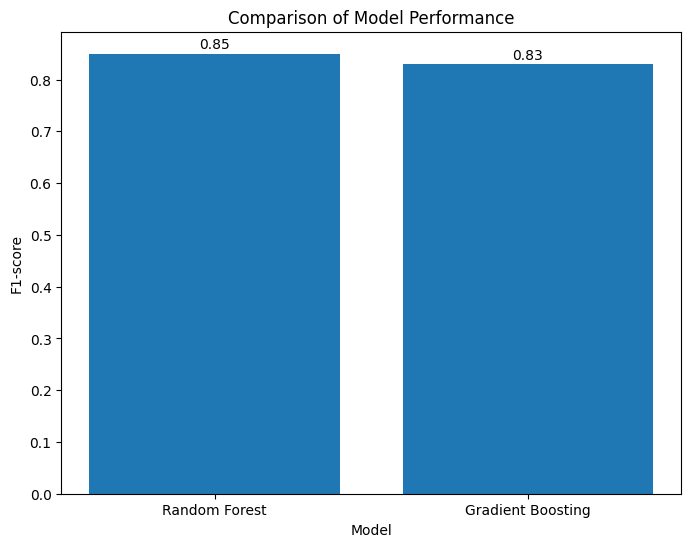

In [ ]:
import matplotlib.pyplot as plt

# Метрики для моделей
rf_f1 = 0.85
gbc_f1 = 0.83

# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(8, 6))

# Построение столбчатой диаграммы
x = ['Random Forest', 'Gradient Boosting']
y = [rf_f1, gbc_f1]
ax.bar(x, y)

# Добавление меток и заголовка
ax.set_xlabel('Model')
ax.set_ylabel('F1-score')
ax.set_title('Comparison of Model Performance')

# Отображение значений на столбцах
for i, v in enumerate(y):
    ax.text(i, v + 0.01, str(round(v, 2)), ha='center', fontsize=10)

# Отображение графика
plt.show()

### Задание 4

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import precision_score

# Создание базовых моделей
base_models = [
    ('decision_tree', DecisionTreeClassifier(max_depth=best_depth, random_state=42)),
    ('logistic_regression', LogisticRegression(solver='sag', random_state=42, max_iter=1000)),
    ('gradient_boosting', GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42))
]

# Создание метамодели
meta_model = LogisticRegression()

# Создание модели стекинга
stacking_model = StackingClassifier(classifiers=[model for _, model in base_models],
                                    meta_classifier=meta_model)

# Обучение модели стекинга
stacking_model.fit(X_train_norm, y_train)

# Предсказание на тестовой выборке
y_pred_stacking = stacking_model.predict(X_test_norm)

# Оценка метрики precision на тестовой выборке
precision_stacking = precision_score(y_test, y_pred_stacking)

# Вывод результата
print("Значение метрики precision для модели стекинга на тестовой выборке:", round(precision_stacking, 3))

Значение метрики precision для модели стекинга на тестовой выборке: 0.797


### Задание 5

Три наиболее значимых признака:
Index(['loan', 'contact_unknown', 'poutcome_success'], dtype='object')


<Figure size 1000x600 with 0 Axes>

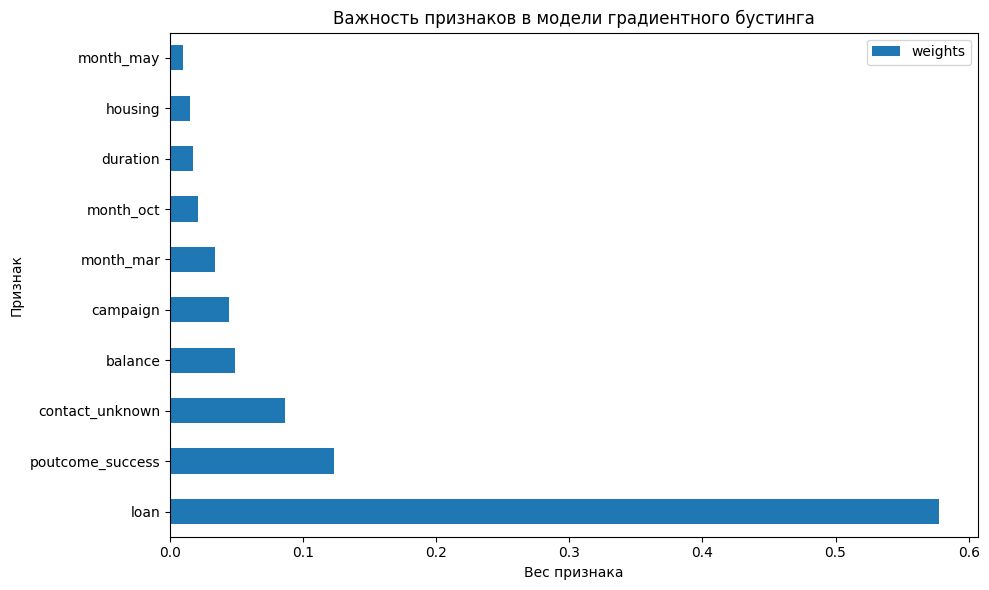

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

# Создаем список названий признаков
feature_names = ['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']

# Создаем DataFrame с названиями признаков
X_train_norm_df = pd.DataFrame(X_train_norm, columns=feature_names)

# Выбор 3 наиболее значимых признаков
selector = SelectKBest(f_classif, k=3)
X_train_selected = selector.fit_transform(X_train_norm, y_train)
X_test_selected = selector.transform(X_test_norm)

# Получение названий выбранных признаков
selected_features = X_train_norm_df.columns[selector.get_support()]
print("Три наиболее значимых признака:")
print(selected_features)

# Обучение модели градиентного бустинга
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_norm, y_train)

# Получение важности признаков
imp_features = gb.feature_importances_

# Создание DataFrame с важностью признаков
df_imp_features = pd.DataFrame({"features": feature_names, "weights": imp_features})

# Сортировка DataFrame по убыванию важности признаков
df_imp_features = df_imp_features.sort_values(by='weights', ascending=False)

# Построение горизонтальной гистограммы
plt.figure(figsize=(10, 6))
df_imp_features.head(10).plot(kind='barh', x='features', y='weights', figsize=(10, 6))
plt.title('Важность признаков в модели градиентного бустинга')
plt.xlabel('Вес признака')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint

# Определение пространства поиска гиперпараметров
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'min_samples_leaf': randint(1, 20)
}

# Создание модели градиентного бустинга
gbc = GradientBoostingClassifier(random_state=42)

# Создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbc, param_distributions=param_dist, n_iter=100, cv=5, scoring='f1', random_state=42, n_jobs=-1)

# Обучение модели с оптимизацией гиперпараметров
random_search.fit(X_train_norm, y_train)

# Получение лучших гиперпараметров
best_params_random = random_search.best_params_

# Создание модели с лучшими гиперпараметрами
best_gbc_random = GradientBoostingClassifier(**best_params_random, random_state=42)
best_gbc_random.fit(X_train_norm, y_train)

# Оценка производительности на тестовых данных
y_pred_test_random = best_gbc_random.predict(X_test_norm)
test_f1_random = f1_score(y_test, y_pred_test_random)
print(f"F1-score на тестовых данных с RandomizedSearchCV: {test_f1_random:.3f}")


F1-score на тестовых данных с RandomizedSearchCV: 0.828


Доп.задание

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Определение пространства поиска гиперпараметров
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [5, 10, 20]
}

# Создание модели градиентного бустинга
gbc = GradientBoostingClassifier(random_state=42)

# Создание объекта GridSearchCV
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Обучение модели с оптимизацией гиперпараметров
grid_search.fit(X_train_norm, y_train)

# Получение лучших гиперпараметров
best_params = grid_search.best_params_

# Создание модели с лучшими гиперпараметрами
best_gbc = GradientBoostingClassifier(**best_params, random_state=42)
best_gbc.fit(X_train_norm, y_train)

# Оценка производительности на тестовых данных
y_pred_test = best_gbc.predict(X_test_norm)
test_f1 = f1_score(y_test, y_pred_test)
print(f"F1-score на тестовых данных: {test_f1:.3f}")


F1-score на тестовых данных: 0.824


Чем выше значение F1-меры, тем лучше качество модели классификации. Следовательно, в данном случае модель, оптимизированная с помощью GridSearchCV, показала немного лучший результат по сравнению с моделью, оптимизированной с помощью Optuna.
Таким образом, в данном конкретном случае, значение F1-меры 0.824, полученное с помощью GridSearchCV, является более высоким и указывает на более качественную модель классификации по сравнению с результатом 0.817, полученным с помощью Optuna.

### Задания 6,7,8

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
import optuna

from sklearn import model_selection
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    scores = model_selection.cross_val_score(model, X_train_norm, y_train, cv=5, scoring='f1_macro')

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_model = ensemble.RandomForestClassifier(**best_params)
best_model.fit(X_train_norm, y_train)
y_pred_test = best_model.predict(X_test_norm)
print(round(metrics.f1_score(y_test, y_pred_test), 3))

print(round(metrics.accuracy_score(y_test, y_pred_test), 3))



[I 2024-05-15 20:18:45,314] A new study created in memory with name: no-name-c81140e8-853d-45d0-b980-1fbfd3522920
[I 2024-05-15 20:18:50,793] Trial 0 finished with value: 0.826263674285115 and parameters: {'n_estimators': 115, 'max_depth': 19, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.826263674285115.
[I 2024-05-15 20:19:08,631] Trial 1 finished with value: 0.8291246376185273 and parameters: {'n_estimators': 169, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8291246376185273.
[I 2024-05-15 20:19:25,337] Trial 2 finished with value: 0.8254843321977907 and parameters: {'n_estimators': 165, 'max_depth': 26, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8291246376185273.
[I 2024-05-15 20:19:43,380] Trial 3 finished with value: 0.8264703072599273 and parameters: {'n_estimators': 185, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8291246376185273.
[I 2024-05-15 20:19:47,583] Trial 4 finished with value: 0.8265875442163754 

0.817
0.828
